In [1]:
import os
import sys
import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict


In [2]:
from collections import defaultdict

num_doc = 1000

dataset_names = ['kp20k', 'openkp', 'kptimes', 'stackex']
# dataset_names = ['kp20k', 'openkp']

KP_DATASET_FIELDS = {'kp20k': ('title', 'abstract', 'keywords', None),
                     'stackex': ('title', 'question', 'tags', 'categories'),
                     'openkp': ('url', 'text', 'KeyPhrases', None),
                     'kptimes': ('title', 'abstract', 'keyword', 'categories')}
dataset_split = 'valid'
json_base_dir = '/zfs1/hdaqing/rum20/kp/data/kp/json' # path on CRC

dataset_src_lens, dataset_tgt_lens, dataset_tgt_nums  = {}, {}, {}    
dataset_unique_kp_count, dataset_unique_preskp_count, dataset_unique_abskp_count = {}, {}, {}

dataset_examples_dict = {}

for dataset_name in dataset_names:
    src_len, tgt_len, tgt_num = [], [], []
    data_examples = []
    num_present_doc, num_present_tgt = 0, 0
    num_absent_doc, num_absent_tgt = 0, 0
    
    unique_kp_count, unique_preskp_count, unique_abskp_count = defaultdict(int), defaultdict(int), defaultdict(int)
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s.json' % dataset_split)
    
    with open(input_json_path, 'r') as input_json:
        for ex_id, json_line in enumerate(input_json):
            if ex_id >= num_doc: break
            ex_dict = json.loads(json_line)
            
            title_field, text_field, keyword_field, _ = KP_DATASET_FIELDS[dataset_name]

            src_str = ex_dict[title_field] + ' . ' + ex_dict[text_field]
            if isinstance(ex_dict[keyword_field], str):
                tgt_kps = ex_dict[keyword_field].split(';')
            else:
                tgt_kps = ex_dict[keyword_field]
            data_examples.append({
                'id': ex_id,
                'src': src_str,
                'tgt': tgt_kps
            })

            src_seq = [t for t in re.split(r'\W', src_str) if len(t) > 0]
            tgt_seqs = [[t for t in re.split(r'\W', p) if len(t) > 0] for p in tgt_kps]
#             [kp_set.add(' '.join(p)) for p in tgt_seqs]
            
            for p in tgt_seqs:
                unique_kp_count[' '.join(p)] += 1
                                             
            src_len.append(len(src_seq))
            tgt_num.append(len(tgt_seqs))
            tgt_len.extend([len(tgt_seq) for tgt_seq in tgt_seqs])
    
    print('num_doc=', len(src_len))
    print('avg_src_len=', np.mean(src_len))
    print('num_tgt=', sum(tgt_num))
    print('num_unique_tgt=', len(unique_kp_count))
    print('avg_tgt_len=', np.mean(tgt_len))
    
    dataset_examples_dict[dataset_name] = data_examples
    dataset_src_lens[dataset_name] = src_len
    dataset_tgt_lens[dataset_name] = tgt_len
    dataset_tgt_nums[dataset_name] = tgt_num
    dataset_unique_kp_count[dataset_name] = unique_kp_count
    

kp20k
num_doc= 1000
avg_src_len= 162.277
num_tgt= 5203
num_unique_tgt= 4411
avg_tgt_len= 2.080338266384778
openkp
num_doc= 1000
avg_src_len= 753.605
num_tgt= 2239
num_unique_tgt= 2186
avg_tgt_len= 2.11746315319339
kptimes
num_doc= 1000
avg_src_len= 807.468
num_tgt= 4895
num_unique_tgt= 2820
avg_tgt_len= 2.217364657814096
stackex
num_doc= 1000
avg_src_len= 202.35
num_tgt= 2663
num_unique_tgt= 1156
avg_tgt_len= 1.3514832895230942


In [3]:
dataset_examples_dict['kp20k'][-1]

{'id': 999,
 'src': 'Development, implementation, and analysis of direct integration offline programming method . Wire bond programming (WBP) consists of information required to drive a wire bond machines movement during the wire bonding process. Wire bond programs consist of three key components: material handling, bonding parameter, and bonding path instructions. Of the three components, the bonding path component requires effort and time the most to prepare, as the preparation of bond path is currently being carried out manually. The manual process is tedious and error prone. In comparison to a manual process, offline programming (OLP) of bonding path creation provides a much more reliable and a less tedious method as it is error proof. OLP can be categorized into two versions, mainly vendor specific OLP and direct integration offline programming (Di-OLP), which is presented in this paper. Vendor specific OLP utilizes bonding diagrams created by a computer-aided design program to ge

### Set up Transformers

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda:0")
print(device)
print(torch.cuda.device_count())

True
GeForce GTX TITAN X
cuda:0
1


In [5]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModel.from_pretrained("roberta-large").to(device)

In [6]:
# dict_keys(['input_ids', 'attention_mask'])
inputs = tokenizer("Hello world!", return_tensors="pt").to(device)
print(inputs['input_ids'].device)

cuda:0


In [7]:
outputs = model(**inputs)

In [8]:
# last_hidden_state=[B,L,H], pooler_output=[B,H]
print(outputs['last_hidden_state'].device)
print(outputs['last_hidden_state'].shape)

cuda:0
torch.Size([1, 5, 1024])


In [9]:
inputs

{'input_ids': tensor([[    0, 31414,   232,   328,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}

In [10]:
outputs['pooler_output'].shape

torch.Size([1, 1024])

In [11]:
outputs['pooler_output'].is_cuda

True

### Generate Phrase Embedding

#### Phrase CLS

In [7]:
phrases = []
labels = []

for d_id, d_name in enumerate(['kp20k', 'openkp', 'kptimes', 'stackex']):
    _phrases = [p for doc in dataset_examples_dict[d_name] for p in doc['tgt']]
    _labels = [d_name] * len(_phrases)
    phrases.extend(_phrases)
    labels.extend(_labels)
    print(d_name, len(_phrases))


kp20k 5203
openkp 2239
kptimes 4895
stackex 2663


In [8]:
print(len(phrases))
print(len(labels))

15000
15000


In [9]:
print(phrases[-10:])

['physical attraction', 'sex differences', 'reliability', 'php', 'url', 'plesk', 'users', 'management', 'debian', 'debian installer']


In [10]:
inputs = tokenizer(phrases, return_tensors="pt", padding=True).to(device)

In [11]:
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['attention_mask'].shape)

dict_keys(['input_ids', 'attention_mask'])
torch.Size([15000, 20])
torch.Size([15000, 20])


In [12]:
inputs['attention_mask'].cpu().numpy()

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [13]:
batch_size = 16
phrase_batches = [phrases[i: i+batch_size] for i in range(0, len(phrases), batch_size)]

cls_outputs, last_hidden_states = [], []
for b in phrase_batches:
    inputs = tokenizer(b, return_tensors='pt', padding=True).to(device)
    outputs = model(**inputs)
    # last_hidden_state=[B,L,H], pooler_output=
    cls_output = outputs['pooler_output'].detach().cpu().numpy().tolist() # [B,H]
    last_hidden_state = outputs['last_hidden_state'].detach().cpu().numpy().tolist() # [B,L,H]
    
    cls_outputs.extend(cls_output)
    last_hidden_states.extend(last_hidden_state)

print(len(cls_outputs))
print(len(last_hidden_states))

15000
15000


In [14]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(cls_outputs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.016s...
[t-SNE] Computed neighbors for 15000 samples in 18.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sa

In [15]:
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

np.unique(df["y"], return_counts=True)

(array(['kp20k', 'kptimes', 'openkp', 'stackex'], dtype=object),
 array([5203, 4895, 2239, 2663]))

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

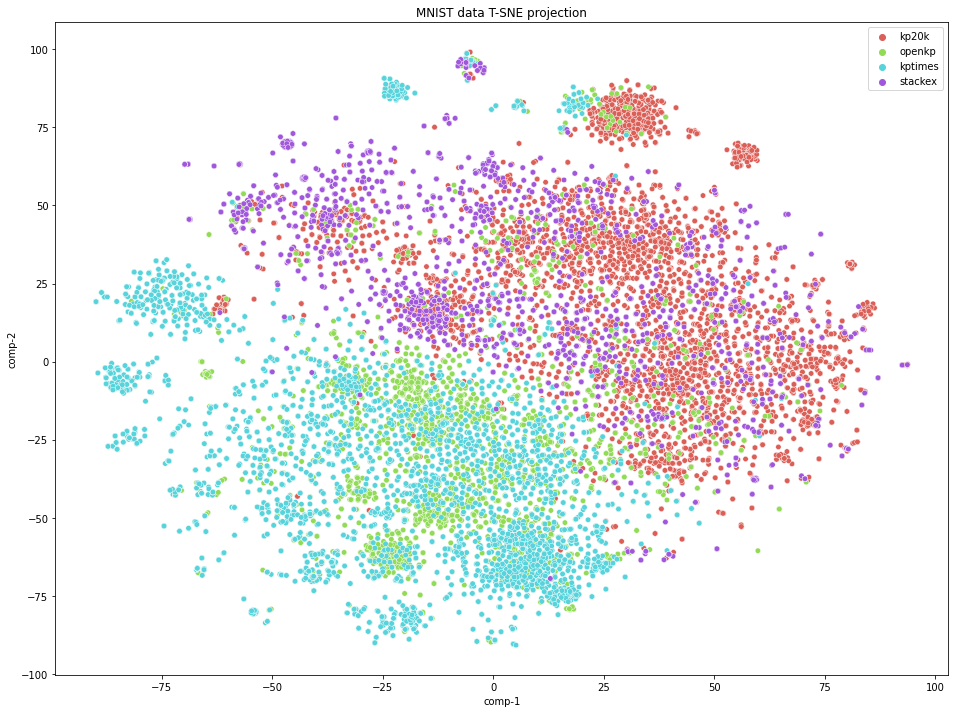

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[16, 12])
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4), s=30,
                data=df).set(title="MNIST data T-SNE projection")

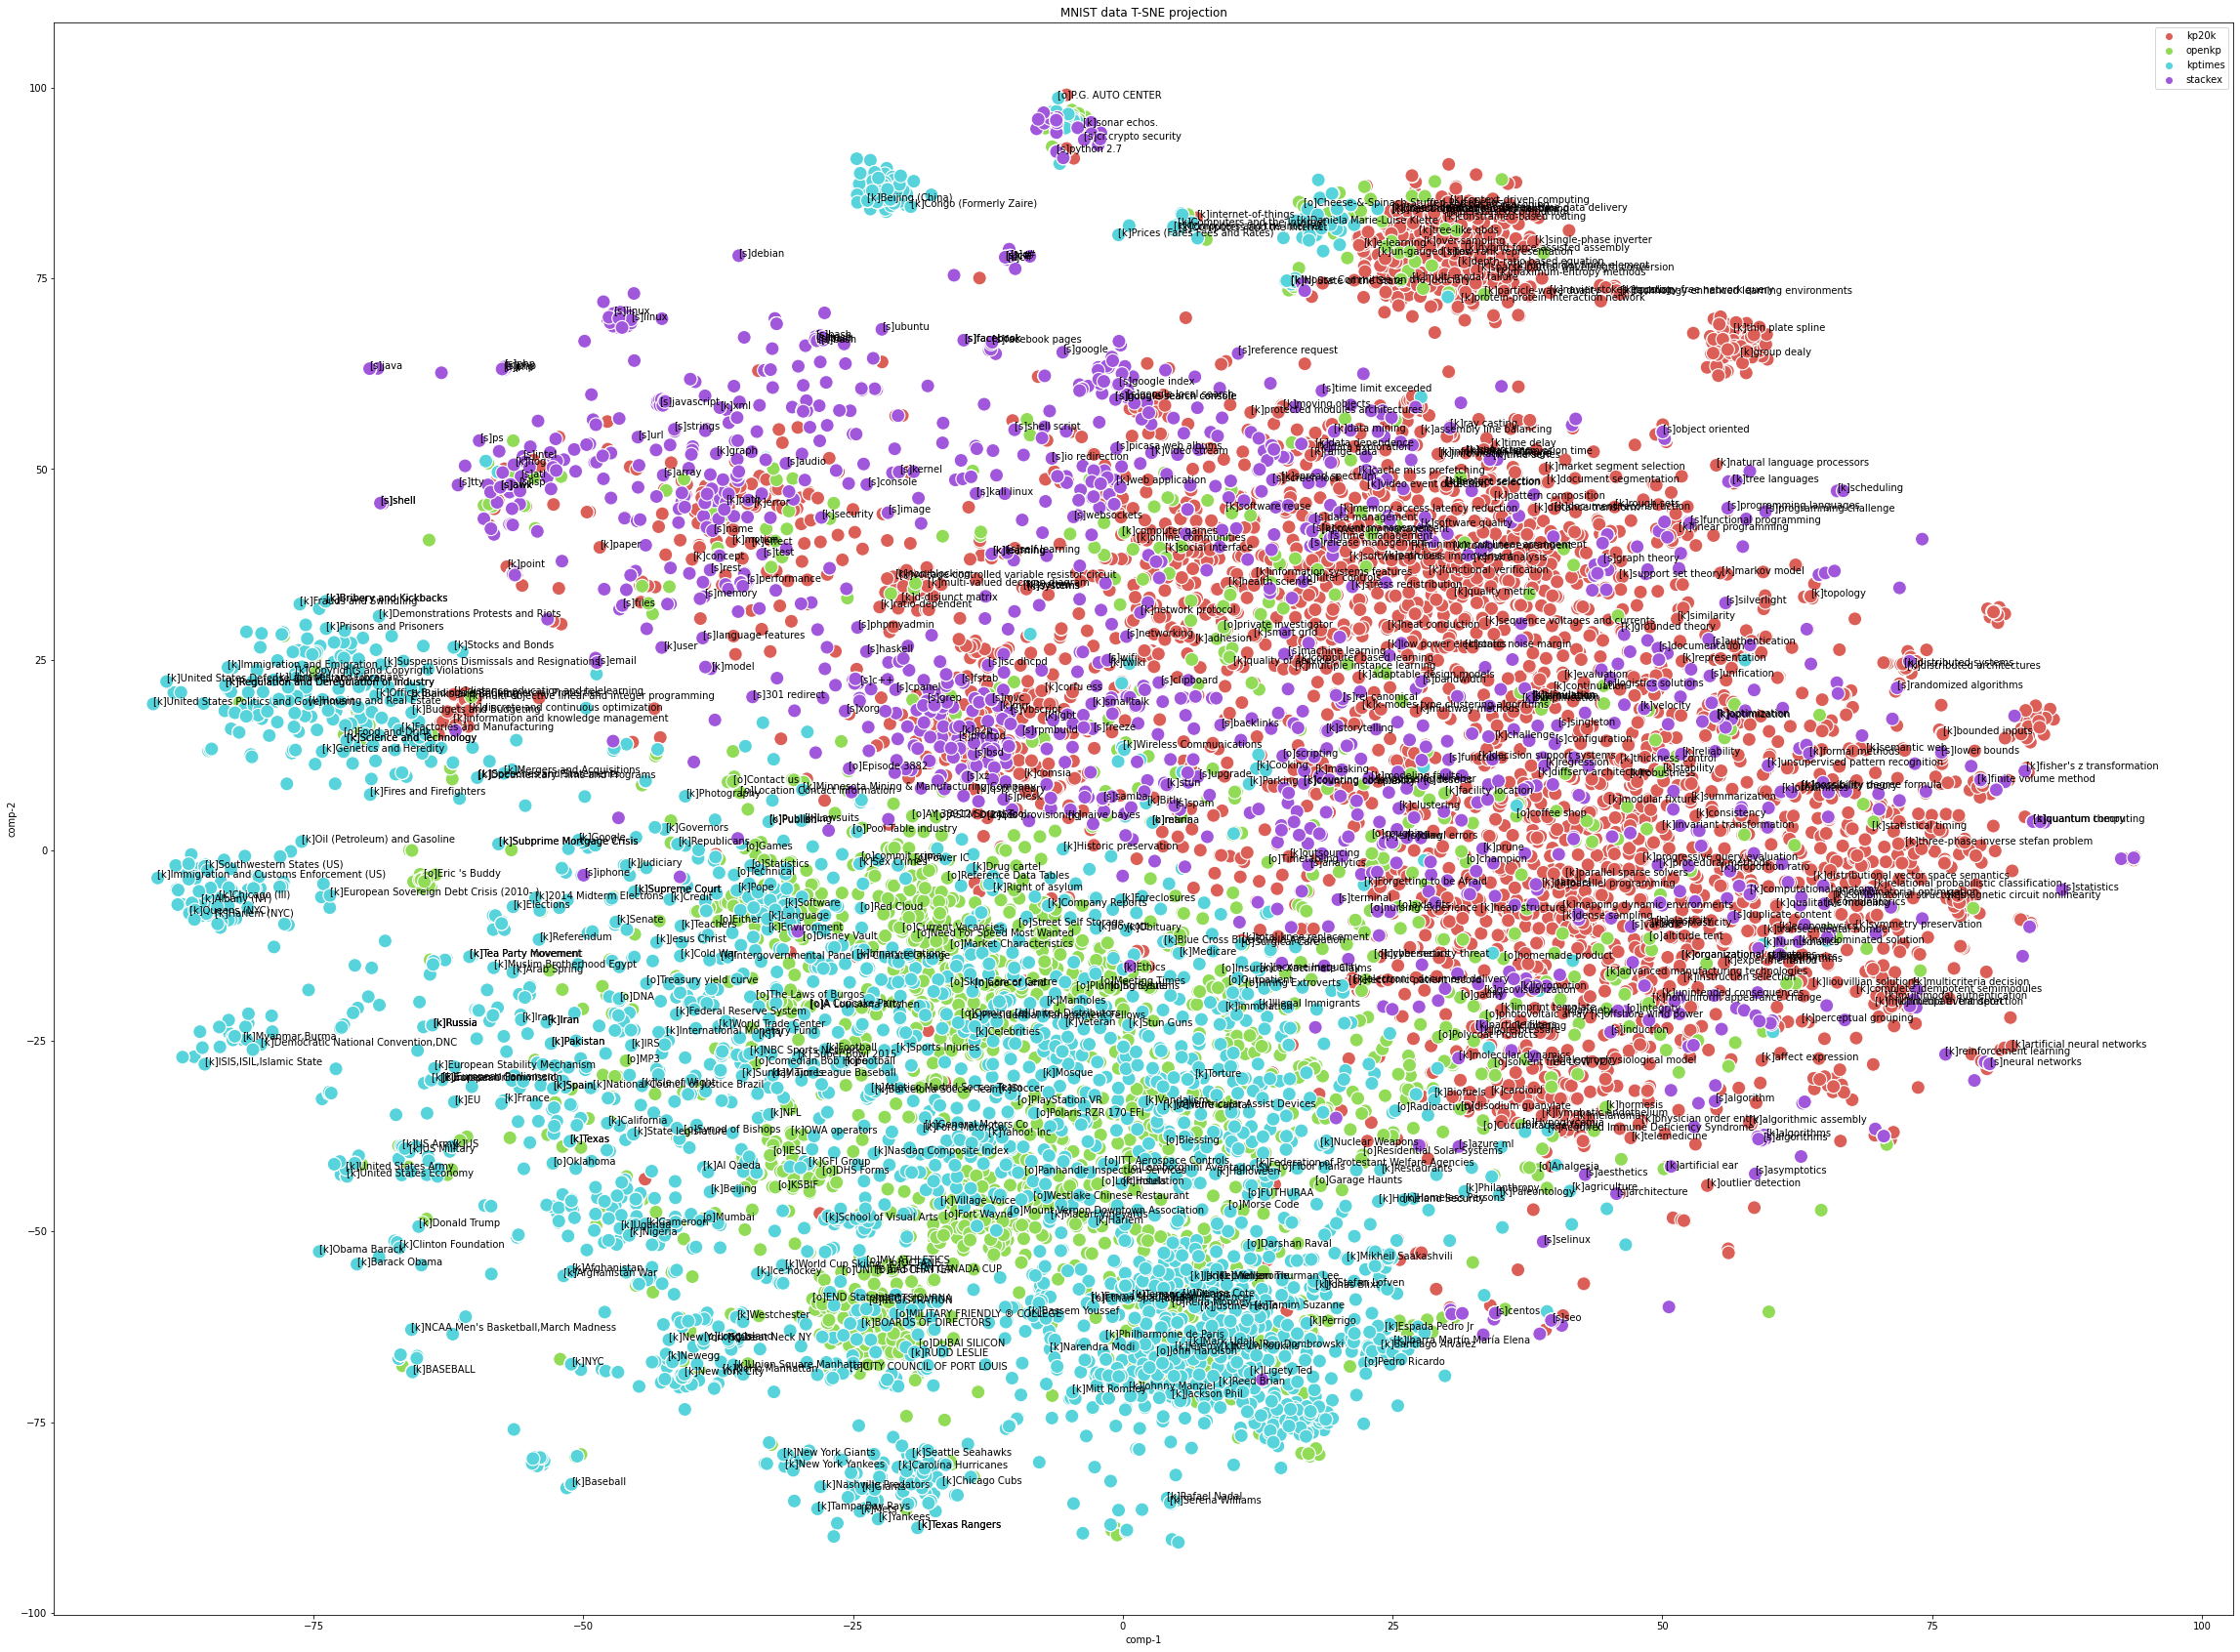

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[40, 30])
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4), s=200,
                data=df).set(title="MNIST data T-SNE projection")

for i, (p, dname) in enumerate(zip(phrases, labels)):
    if i % 21 == 0:
        ax.annotate('[%s]%s' % (dname[0], p), (z[i][0], z[i][1]))

#### Pooled 